In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(factoextra)
library(ggrepel)
library(dplyr)
library(plyr)
library(cowplot)
library(patchwork)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [394]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC_H <- color_ND
color_CHC_M <- "#FFCC00"
color_CHC_L <- "#FF3300"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [129]:
setwd("~/ownCloud/Meng/")

In [130]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

In [131]:
colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "Autopsy_nr"                         
 [5] "GROUP"                               "Mass-Spec filenames (1)"            
 [7] "Mass-Spec filenames (2)"             "Diagnosis"                          
 [9] "sex"                                 "age"                                
[11] "braak"                               "amyloid"                            
[13] "pmd"                                 "ph"                                 
[15] "weight"                              "csf"                                
[17] "apoe"                                "barcode"                            
[19] "Abeta"                               "APOE"

In [258]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype_v2.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [132]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

#metadata <- read_excel("100_plus_project/Metadata/2019_07_23_Proteomics_Metadata_forMeng_v3.xlsx",
#                       sheet=1,col_names=TRUE, na="NA")
#metadata <- as.data.frame(metadata)
#colnames(metadata)

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which(metadata$apoe %in% c(22)),]$apoe_OR <- 0.24
metadata[which(metadata$apoe %in% c(23, 32)),]$apoe_OR <- 0.5
metadata[which(metadata$apoe %in% c(33)),]$apoe_OR <- 1.0
metadata[which(metadata$apoe %in% c(24, 42)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe %in% c(34, 43)),]$apoe_OR <- 5.5
metadata[which(metadata$apoe %in% c(44)),]$apoe_OR <- 20.6

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)

[1] 3448  191

In [133]:
summary(metadata)

     nbb              autopsy              sex                 age       
 Length:190         Length:190         Length:190         Min.   : 50.0  
 Class :character   Class :character   Class :character   1st Qu.: 78.0  
 Mode  :character   Mode  :character   Mode  :character   Median : 89.0  
                                                          Mean   : 86.8  
                                                          3rd Qu.:100.0  
                                                          Max.   :111.0  
    weight             GROUP               pmd                braak      
 Length:190         Length:190         Length:190         Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :4.000  
                                                          Mean   :3.611  
                                                          3rd Qu.:5.000  
                                      

In [134]:
High_quality_protein_intensity_noprotein <- High_quality_protein_intensity_matrix[, -1]

In [135]:
High_quality_protein_intensity_noprotein

intensity_20190325_121_S16_020_CHC_011
1      836.80987                           
2     1344.34121                           
3      563.31659                           
4       33.40392                           
5     3326.60924                           
6      508.48022                           
7     2369.33932                           
8     7124.78872                           
9     1028.55835                           
10     663.97118                           
11     123.46592                           
12    1906.08224                           
13     337.04942                           
14    1768.11308                           
15      96.13215                           
16    3158.82341                           
17     275.06173                           
18    2697.05149                           
19     789.47049                           
20     358.51257                           
21    1347.40137                           
22     140.78761                           
23   20076.39270                           
24    2330.57226                           
25     546.60163                           
26   17834.79847                           
27     102.99731                           
28      87.08684                           
29   11983.49310                           
30      58.76281                           
⋮    ⋮                                     
3419   216.16034                           
3420    56.54726                           
3421    18.34902                           
3422   874.55376                           
3423    17.77719                           
3424  2868.60823                           
3425   374.00680                           
3426    34.72123                           
3427 62768.18872                           
3428 10001.43856                           
3429    56.68148                           
3430    35.52444                           
3431   103.40813                           
3432   906.50345                           
3433    64.56487                           
3434   102.21511                           
3435    30.81992                           
3436    43.60532                           
3437   240.19773                           
3438   136.74496                           
3439   171.97973                           
3440   229.91953                           
3441    33.53112                           
3442    35.17110                           
3443   120.06536                           
3444    68.69914                           
3445   576.64952                           
3446    60.61889                           
3447    50.09336                           
3448    68.45759                           
     intensity_20190325_125_S16_044_CHC_007
1      881.06951                           
2     1049.89367                           
3      208.31086                           
4       75.57282                           
5     4564.59875                           
6      571.96033                           
7     1029.75211                           
8     6129.39109                           
9      767.89888                           
10     435.31397                           
11     135.82106                           
12    1562.32753                           
13     365.39823                           
14    1971.75077                           
15      55.53224                           
16    2680.40900                           
17     271.26194                           
18    2154.48898                           
19     949.84805                           
20     470.01068                           
21    1289.28355                           
22     220.68721                           
23   21394.05450                           
24    2157.76167                           
25     830.79981                           
26   18057.97378                           
27     166.70616                           
28      83.31784                           
2

In [90]:
pdf("100_plus_plots/proteomics/intensity_boxplot_per_sample_log2.pdf", 
    width = 12, height = 8)
boxplot(log2(High_quality_protein_intensity_noprotein[, order(metadata$GROUP)]), xaxt = "n", yaxt = "n", ylim = c(4, 12))

axis(side = 1, labels = FALSE)
axis(side = 2, las = 2, mgp = c(3, 0.75, 0))

text(x = 1:190,
     y = par("usr")[3] - 0.45,
     labels = metadata$GROUP[order(metadata$GROUP)],
     xpd = NA,
     ## Rotate the labels by 90 degrees.
     srt = 90,
     cex = 1.2)

dev.off()

pdf 
  2

In [114]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [98]:
pdf("100_plus_plots/proteomics/intensity_boxplot_per_sample_after_combat_log2.pdf", 
    width = 12, height = 8)
boxplot(protein_intensity_combat[, order(metadata$GROUP)], xaxt = "n", yaxt = "n", ylim = c(4, 12))

axis(side = 1, labels = FALSE)
axis(side = 2, las = 2, mgp = c(3, 0.75, 0))

text(x = 1:190,
     y = par("usr")[3] - 0.45,
     labels = metadata$GROUP[order(metadata$GROUP)],
     xpd = NA,
     ## Rotate the labels by 35 degrees.
     srt = 90,
     cex = 1.2)

dev.off()

pdf 
  2

In [115]:
protein_intensity_combat_nonlog <- 2^protein_intensity_combat

In [116]:
protein_intensity_combat

intensity_20190325_121_S16_020_CHC_011
SLC12A2                             9.687328                             
CASKIN1                            10.318229                             
GNG2                                8.794196                             
CARNS1                              5.214262                             
FH                                 11.643708                             
EFHD2                               9.034089                             
PCLO                               11.115460                             
HSPA1A;HSPA1B                      12.787109                             
STIP1                               9.835297                             
CTNND1                              9.316259                             
INPP5A                              6.924658                             
SEPT11                             10.849092                             
PKP4                                8.242205                             
RYR2                               10.754379                             
PTPRK                               6.377188                             
CAMKV                              11.679212                             
BCR                                 8.077708                             
NDUFV2                             11.248621                             
IDH3B                               9.667242                             
FMNL2                               8.541107                             
SYT12                              10.314867                             
GRHPR                               7.101698                             
CSE1L                              14.257921                             
DNAJC6                             11.146288                             
DUSP3                               8.883316                             
VDAC3                              14.126410                             
PITPNM3                             6.672799                             
SRPK2                               6.331298                             
AP2A1                              13.523965                             
RCN1                                5.810164                             
⋮                                  ⋮                                     
KLC1;KLC2;KLC4                      7.466161                             
TM9SF3                              5.769128                             
PLEKHA6                             4.103650                             
KCTD12;KCTD16                       9.704545                             
SLC16A7                             4.273874                             
PPP3CA;PPP3CB;PPP3CC               11.512149                             
EHD3;EHD4                           8.514007                             
PEX14                               5.074460                             
TUBB;TUBB4A;TUBB4B                 16.092348                             
TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3 13.129337                             
PTPRD;PTPRF                         5.849712                             
H1F0                                5.486699                             
FAM210A                             6.598159                             
EPB41;EPB41L1;EPB41L3              10.041608                             
PABPN1                              5.955518                             
KCND2;KCND3                         6.546510                             
JMJD7;PLA2G4B                       4.589614                             
U2AF1;U2AF1L4;U2AF1L5               5.379518                             
ATP6V1G1;ATP6V1G2                   7.429347                             
ATP5J2;ATP5MF                       7.181584                             
ACTB                                7.365504                             
ACTG1                               7.665608                             
CHMP1A                              5.0

In [195]:
protein_intensity_combat_std <- t(scale(t(protein_intensity_combat), 
                                        center = TRUE, scale = TRUE)) %>% as.data.frame()

In [196]:
rowMeans(protein_intensity_combat_std)
rowSds(protein_intensity_combat_std)

SLC12A2 
                                                                                                                                    -1.800164e-15 
                                                                                                                                          CASKIN1 
                                                                                                                                    -1.410421e-15 
                                                                                                                                             GNG2 
                                                                                                                                     4.605006e-16 
                                                                                                                                           CARNS1 
                                                                                                                                     4.047749e-16 
                                                                                                                                               FH 
                                                                                                                                     1.697253e-15 
                                                                                                                                            EFHD2 
                                                                                                                                     3.604002e-16 
                                                                                                                                             PCLO 
                                                                                                                                     1.258469e-15 
                                                                                                                                    HSPA1A;HSPA1B 
                                                                                                                                    -7.562253e-16 
                                                                                                                                            STIP1 
                                                                                                                                    -1.062504e-15 
                                                                                                                                           CTNND1 
                                                                                                                                     2.020222e-16 
                                                                                                                                           INPP5A 
                                                                                                                                    -6.640750e-16 
                                                                                                                                           SEPT11 
                                                                                                                                     2.853127e-15 
                                                                                                                                             PKP4 
                                                                                                                                    -2.963565e-15 
                                                                                                                                             RYR2 
                                                                                                                                    -1.095432e-16 
                      

SLC12A2 
                                                                                                                                                1 
                                                                                                                                          CASKIN1 
                                                                                                                                                1 
                                                                                                                                             GNG2 
                                                                                                                                                1 
                                                                                                                                           CARNS1 
                                                                                                                                                1 
                                                                                                                                               FH 
                                                                                                                                                1 
                                                                                                                                            EFHD2 
                                                                                                                                                1 
                                                                                                                                             PCLO 
                                                                                                                                                1 
                                                                                                                                    HSPA1A;HSPA1B 
                                                                                                                                                1 
                                                                                                                                            STIP1 
                                                                                                                                                1 
                                                                                                                                           CTNND1 
                                                                                                                                                1 
                                                                                                                                           INPP5A 
                                                                                                                                                1 
                                                                                                                                           SEPT11 
                                                                                                                                                1 
                                                                                                                                             PKP4 
                                                                                                                                                1 
                                                                                                                                             RYR2 
                                                                                                                                                1 
                      

In [197]:
High_quality_protein_intensity_log2 <- log2(High_quality_protein_intensity_noprotein)

In [198]:
High_quality_protein_intensity_std <- t(scale(t(High_quality_protein_intensity_log2), 
                                               center = TRUE, scale = TRUE)) %>% as.data.frame()

In [199]:
rowMeans(High_quality_protein_intensity_std)
rowSds(High_quality_protein_intensity_std)

[1] -4.215926e-16 -3.824472e-16  3.192622e-16  4.236971e-16  7.882492e-16
   [6] -8.204055e-16  7.092645e-16  1.439273e-16 -6.091436e-16 -3.017533e-15
  [11]  6.455636e-16 -1.900771e-15 -1.970062e-15 -1.352929e-15  4.332563e-16
  [16]  3.953673e-15 -5.315193e-16  2.089520e-16 -2.883330e-15 -2.280659e-16
  [21]  1.556065e-15  8.693704e-17  2.348542e-15  2.615233e-16  1.866946e-15
  [26] -3.829110e-15 -5.141173e-17 -5.801326e-16 -2.343675e-15  7.690303e-17
  [31]  5.708747e-15 -5.798541e-16 -9.206177e-16 -2.781462e-15  1.215429e-15
  [36] -4.931581e-15 -1.914621e-15  4.771740e-15 -4.437715e-15 -4.648009e-16
  [41] -2.942045e-15 -1.129652e-15  4.313801e-16 -6.476727e-16 -1.769418e-17
  [46] -2.772819e-17 -2.640833e-15 -2.386121e-15  4.790758e-16  8.401266e-16
  [51]  3.200108e-16 -1.771500e-15  6.254637e-16  1.771609e-15  1.256853e-15
  [56] -5.175118e-15 -1.635808e-15  3.501841e-15 -2.062659e-15 -1.680043e-15
  [61] -1.245020e-15  5.488072e-15 -1.196946e-15 -8.978929e-16  9.904358e-17
  [66]  5.582979e-16 -4.332700e-16  1.522822e-15  1.391029e-15  7.306838e-17
  [71] -8.833760e-16 -5.739470e-16  2.746601e-15  1.058606e-15 -9.150210e-17
  [76] -6.710823e-16 -5.190494e-15 -2.525301e-16 -1.049106e-15  6.685533e-16
  [81]  1.560338e-16  1.463929e-15  1.666804e-15 -5.284748e-15 -5.548924e-16
  [86]  3.474779e-15 -1.687361e-16  2.313153e-15  3.854003e-15 -4.555804e-15
  [91]  5.937502e-16  4.626576e-15 -1.539218e-15 -4.340933e-15 -4.041901e-15
  [96] -1.146648e-15 -8.226241e-16 -2.283334e-15  1.174641e-15  4.432616e-15
 [101] -3.442540e-15 -1.366437e-15  1.772522e-16  1.264965e-15  1.538828e-15
 [106] -9.134438e-16  5.254751e-16  7.275978e-16 -2.244089e-15  2.705621e-15
 [111] -3.355320e-15 -1.051252e-15 -1.420223e-15 -5.094335e-16  9.262510e-17
 [116]  1.230193e-15 -2.451438e-16 -1.616927e-15 -1.938029e-15 -2.010453e-16
 [121] -2.391371e-15 -1.709150e-15  1.980260e-15  4.948847e-16  7.442238e-16
 [126]  9.651728e-16 -1.024797e-15 -9.359997e-16 -2.199310e-15 -1.073401e-15
 [131]  1.240875e-15 -7.905911e-16 -2.557640e-15  8.008123e-16  9.343677e-16
 [136]  1.926173e-15  1.887653e-17 -2.526625e-15  5.691993e-16 -6.726619e-16
 [141] -2.435588e-15 -1.158430e-16  3.315499e-15 -2.771632e-15 -7.649674e-16
 [146] -2.041340e-15  4.366664e-16  1.838807e-17  1.267992e-16 -2.391864e-16
 [151] -4.578917e-15  1.002049e-15 -7.267122e-17 -2.174951e-15 -3.028425e-15
 [156]  1.242802e-15  5.126473e-15 -2.446873e-18  4.833305e-16 -4.124305e-15
 [161] -6.004700e-16  3.742691e-15  5.171485e-16 -1.821318e-15  1.389787e-16
 [166]  6.452167e-16 -7.216176e-16 -1.882435e-15  7.083698e-16  2.014799e-15
 [171] -3.473537e-15 -2.690492e-15 -1.561447e-15  1.561374e-15  1.375362e-15
 [176] -6.177944e-16  8.567434e-16 -1.064235e-15 -6.455271e-16 -2.160562e-15
 [181] -1.745680e-16  4.433268e-16  2.473232e-15  8.295448e-16  7.963979e-16
 [186]  1.306708e-15  1.280965e-15 -1.004916e-15  1.330277e-15  1.405336e-15
 [191] -7.069820e-16  3.037241e-15  2.097874e-15 -3.402121e-15 -3.027987e-15
 [196] -1.601022e-15 -4.326464e-15 -4.700493e-15  1.188404e-15  6.419527e-16
 [201] -2.303302e-15 -1.500974e-15  1.580945e-15  4.776881e-17  2.549121e-15
 [206]  1.469932e-15 -6.394008e-16  5.030424e-16 -6.006526e-16  9.599868e-16
 [211] -9.704500e-16  2.540457e-16  1.257099e-15  9.994803e-16  4.130925e-15
 [216] -1.425495e-15  9.934020e-16 -4.497453e-16  1.736002e-16 -9.263241e-16
 [221] -2.539553e-15  7.528289e-16  1.662322e-16 -2.697276e-15 -2.513943e-15
 [226] -1.447485e-15 -4.274245e-16  3.008741e-15  3.986942e-16  4.513842e-16
 [231] -2.222135e-15  3.286395e-15  1.063171e-15 -2.133838e-15 -1.926620e-15
 [236]  6.771402e-16 -2.882389e-15  1.975467e-15  1.083709e-15  3.298348e-16
 [241]  1.844203e-15  8.420165e-16 -1.123439e-16 -1.282358e-15 -2.224281e-15
 [246]  3.272072e-15  1.014124e-15 -2.189038e-16  8.638078e-16 -2.041267e-16
 [251]  5.283237e-16  9.969730e-16 -2.983546e-15  1.034480e-15 -2.105623e-15
 [256]  7.555702e-16  2.195959e-15  4.309053e-16 -3.161214e-16 -3.171339e-15

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [334] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [371] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [408] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [445] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [482] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [519] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [556] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [593] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [630] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [667] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [704] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [741] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [778] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [815] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [852] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [889] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [926] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [963] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1000] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1037] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1074] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1111] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1148] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1185] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1222] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1259] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1296] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1333] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1370] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1407] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1444] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1481] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1518] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1555] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1592] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1629] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1666] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1703] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1740] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1777] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1814] 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [355]:
High_quality_protein_intensity_std_sample <- scale(High_quality_protein_intensity_log2, 
                                                   center = TRUE, scale = TRUE) %>% as.data.frame()

In [356]:
colMeans(High_quality_protein_intensity_std_sample)
apply(High_quality_protein_intensity_std_sample, 2, sd)

intensity_20190325_121_S16_020_CHC_011 
                             -2.773354e-16 
    intensity_20190325_125_S16_044_CHC_007 
                             -3.532894e-16 
    intensity_20190325_127_S16_094_CHC_004 
                             -1.995415e-16 
       intensity_20190325_16_04_037_AD_008 
                              1.499268e-16 
     intensity_20190325_183_S10_292_AD_010 
                              6.169739e-17 
     intensity_20190325_194_S02_055_ND_005 
                              1.185629e-16 
       intensity_20190325_31_01_184_AD_006 
                             -3.825448e-17 
      intensity_20190325_57_S97_235_AD_003 
                             -1.009541e-16 
      intensity_20190325_77_S11_072_ND_012 
                              2.574414e-16 
      intensity_20190325_79_S07_308_ND_009 
                              1.668313e-18 
      intensity_20190325_95_S05_217_ND_002 
                             -2.526921e-16 
    intensity_20190326_123_S16_032_CHC_020 
                             -1.994862e-16 
   intensity_20190326_136_2017_014_CHC_014 
                             -2.422777e-16 
   intensity_20190326_151_2017_129_CHC_017 
                              5.103146e-17 
     intensity_20190326_176_S04_088_AD_021 
                              2.451595e-16 
     intensity_20190326_195_S03_035_ND_024 
                              2.473943e-16 
     intensity_20190326_201_S08_325_ND_019 
                             -1.420360e-16 
     intensity_20190326_203_S09_067_ND_016 
                              3.862970e-16 
   intensity_20190326_220_SVU10_277_ND_022 
                              3.492570e-16 
       intensity_20190326_4_S05_106_AD_015 
                              1.198026e-16 
       intensity_20190326_74_01_059_AD_013 
                              2.572100e-16 
     intensity_20190328_100_S14_051_ND_032 
                             -3.737705e-16 
  intensity_20190328_108_NABCA15_08_ND_028 
                             -1.017772e-16 
    intensity_20190328_120_S16_008_CHC_030 
                              3.755626e-16 
    intensity_20190328_126_S16_058_CHC_036 
                             -3.051503e-16 
      intensity_20190328_12_S00_206_AD_031 
                              1.351474e-16 
    intensity_20190328_130_S16_109_CHC_034 
                             -2.968752e-17 
   intensity_20190328_143_2017_053_CHC_026 
                             -1.517782e-16 
     intensity_20190328_172_S02_214_AD_027 
                              2.397078e-16 
     intensity_20190328_176_S03_150_AD_033 
                             -3.400571e-16 
     intensity_20190328_184_S10_321_AD_025 
                             -1.388302e-16 
      intensity_20190328_62_S01_195_AD_029 
                              1.193558e-16 
      intensity_20190328_89_S13_010_ND_035 
                             -1.229621e-16 
   intensity_20190329_145_2017_072_CHC_039 
                              2.656824e-16 
   intensity_20190329_167_2018_086_CHC_045 
                              4.835894e-18 
     intensity_20190329_171_S02_010_AD_046 
                             -3.705768e-16 
     intensity_20190329_191_S11_116_AD_037 
                             -2.808079e-16 
     intensity_20190329_196_S03_068_ND_040 
                              5.700841e-17 
     intensity_20190329_212_S12_005_ND_038 
                              2.863833e-16 
     intensity_20190329_213_S12_049_ND_047 
                              3.112058e-16 
      intensity_20190329_35_S02_131_AD_043 
                             -4.922228e-17 
      intensity_20190329_49_S11_053_AD_041 
                              1.471315e-16 
       intensity_20190329_73_00_086_AD_048 
                             -1.257473e-16 
     intensity_20190401_179_S06_264_AD_059 
                             -1.841222e-16 
     intensity_20190401_197_S04_188_ND_050 
                              1.232036e-16 
     intensity_20190401_205_S09_311_ND_052 


intensity_20190325_121_S16_020_CHC_011 
                                         1 
    intensity_20190325_125_S16_044_CHC_007 
                                         1 
    intensity_20190325_127_S16_094_CHC_004 
                                         1 
       intensity_20190325_16_04_037_AD_008 
                                         1 
     intensity_20190325_183_S10_292_AD_010 
                                         1 
     intensity_20190325_194_S02_055_ND_005 
                                         1 
       intensity_20190325_31_01_184_AD_006 
                                         1 
      intensity_20190325_57_S97_235_AD_003 
                                         1 
      intensity_20190325_77_S11_072_ND_012 
                                         1 
      intensity_20190325_79_S07_308_ND_009 
                                         1 
      intensity_20190325_95_S05_217_ND_002 
                                         1 
    intensity_20190326_123_S16_032_CHC_020 
                                         1 
   intensity_20190326_136_2017_014_CHC_014 
                                         1 
   intensity_20190326_151_2017_129_CHC_017 
                                         1 
     intensity_20190326_176_S04_088_AD_021 
                                         1 
     intensity_20190326_195_S03_035_ND_024 
                                         1 
     intensity_20190326_201_S08_325_ND_019 
                                         1 
     intensity_20190326_203_S09_067_ND_016 
                                         1 
   intensity_20190326_220_SVU10_277_ND_022 
                                         1 
       intensity_20190326_4_S05_106_AD_015 
                                         1 
       intensity_20190326_74_01_059_AD_013 
                                         1 
     intensity_20190328_100_S14_051_ND_032 
                                         1 
  intensity_20190328_108_NABCA15_08_ND_028 
                                         1 
    intensity_20190328_120_S16_008_CHC_030 
                                         1 
    intensity_20190328_126_S16_058_CHC_036 
                                         1 
      intensity_20190328_12_S00_206_AD_031 
                                         1 
    intensity_20190328_130_S16_109_CHC_034 
                                         1 
   intensity_20190328_143_2017_053_CHC_026 
                                         1 
     intensity_20190328_172_S02_214_AD_027 
                                         1 
     intensity_20190328_176_S03_150_AD_033 
                                         1 
     intensity_20190328_184_S10_321_AD_025 
                                         1 
      intensity_20190328_62_S01_195_AD_029 
                                         1 
      intensity_20190328_89_S13_010_ND_035 
                                         1 
   intensity_20190329_145_2017_072_CHC_039 
                                         1 
   intensity_20190329_167_2018_086_CHC_045 
                                         1 
     intensity_20190329_171_S02_010_AD_046 
                                         1 
     intensity_20190329_191_S11_116_AD_037 
                                         1 
     intensity_20190329_196_S03_068_ND_040 
                                         1 
     intensity_20190329_212_S12_005_ND_038 
                                         1 
     intensity_20190329_213_S12_049_ND_047 
                                         1 
      intensity_20190329_35_S02_131_AD_043 
                                         1 
      intensity_20190329_49_S11_053_AD_041 
                                         1 
       intensity_20190329_73_00_086_AD_048 
                                         1 
     intensity_20190401_179_S06_264_AD_059 
                                         1 
     intensity_20190401_197_S04_188_ND_050 
                                         1 
     intensity_20190401_205_S09_311_ND_052 


In [334]:
protein_intensity_combat

intensity_20190325_121_S16_020_CHC_011
SLC12A2                             9.687328                             
CASKIN1                            10.318229                             
GNG2                                8.794196                             
CARNS1                              5.214262                             
FH                                 11.643708                             
EFHD2                               9.034089                             
PCLO                               11.115460                             
HSPA1A;HSPA1B                      12.787109                             
STIP1                               9.835297                             
CTNND1                              9.316259                             
INPP5A                              6.924658                             
SEPT11                             10.849092                             
PKP4                                8.242205                             
RYR2                               10.754379                             
PTPRK                               6.377188                             
CAMKV                              11.679212                             
BCR                                 8.077708                             
NDUFV2                             11.248621                             
IDH3B                               9.667242                             
FMNL2                               8.541107                             
SYT12                              10.314867                             
GRHPR                               7.101698                             
CSE1L                              14.257921                             
DNAJC6                             11.146288                             
DUSP3                               8.883316                             
VDAC3                              14.126410                             
PITPNM3                             6.672799                             
SRPK2                               6.331298                             
AP2A1                              13.523965                             
RCN1                                5.810164                             
⋮                                  ⋮                                     
KLC1;KLC2;KLC4                      7.466161                             
TM9SF3                              5.769128                             
PLEKHA6                             4.103650                             
KCTD12;KCTD16                       9.704545                             
SLC16A7                             4.273874                             
PPP3CA;PPP3CB;PPP3CC               11.512149                             
EHD3;EHD4                           8.514007                             
PEX14                               5.074460                             
TUBB;TUBB4A;TUBB4B                 16.092348                             
TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3 13.129337                             
PTPRD;PTPRF                         5.849712                             
H1F0                                5.486699                             
FAM210A                             6.598159                             
EPB41;EPB41L1;EPB41L3              10.041608                             
PABPN1                              5.955518                             
KCND2;KCND3                         6.546510                             
JMJD7;PLA2G4B                       4.589614                             
U2AF1;U2AF1L4;U2AF1L5               5.379518                             
ATP6V1G1;ATP6V1G2                   7.429347                             
ATP5J2;ATP5MF                       7.181584                             
ACTB                                7.365504                             
ACTG1                               7.665608                             
CHMP1A                              5.0

In [335]:
metadata$batch <- cal_sample_batch_index(metadata$filenames) + 1

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”

In [336]:
table(metadata$batch)


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 7  8  6  8  8  6  4  3  5  6  7  7  6  7  8  6  7  7  8  8  8  8  7  6  7  6 
27 28 29 
 6  5  5 

In [337]:
expression_summary <- cbind(metadata, 
                            totalEXP_Combat = as.vector(apply(protein_intensity_combat, 2, mean)), 
                            totalEXP_orig = as.vector(apply(log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                                                 2, mean)))

In [357]:
expression_summary <- cbind(metadata, 
                            totalEXP_Combat = as.numeric(apply(protein_intensity_combat, 2, mean)), 
                            totalEXP_Combat_std = as.numeric(apply(protein_intensity_combat_std, 2, mean)),
                            totalEXP_orig = as.numeric(apply(High_quality_protein_intensity_log2, 2, mean)), 
                            totalEXP_orig_std = as.numeric(apply(High_quality_protein_intensity_std, 2, mean)), 
                            totalEXP_orig_std_sample = as.numeric(apply(High_quality_protein_intensity_std_sample, 2, mean)))

In [201]:
protein_intensity_combat_std

intensity_20190325_121_S16_020_CHC_011
SLC12A2                            -0.5886391                            
CASKIN1                             2.0849880                            
GNG2                                1.9932239                            
CARNS1                             -1.7729265                            
FH                                 -0.9416947                            
EFHD2                              -0.8896351                            
PCLO                                0.9204595                            
HSPA1A;HSPA1B                      -0.3049227                            
STIP1                              -0.3338112                            
CTNND1                              2.0412121                            
INPP5A                             -0.4848991                            
SEPT11                              0.3725832                            
PKP4                                0.4231511                            
RYR2                                0.2381576                            
PTPRK                               0.6465857                            
CAMKV                               1.3397814                            
BCR                                 0.8666975                            
NDUFV2                              0.8290629                            
IDH3B                              -1.4300642                            
FMNL2                              -1.3616862                            
SYT12                               1.3397241                            
GRHPR                              -1.6147591                            
CSE1L                              -0.5315217                            
DNAJC6                              0.8497961                            
DUSP3                              -2.1702799                            
VDAC3                               0.9705041                            
PITPNM3                            -0.4726833                            
SRPK2                               0.7639853                            
AP2A1                               1.3419977                            
RCN1                               -0.5140419                            
⋮                                  ⋮                                     
KLC1;KLC2;KLC4                      2.26768784                           
TM9SF3                              1.74449440                           
PLEKHA6                            -0.08302222                           
KCTD12;KCTD16                       0.69600220                           
SLC16A7                            -0.27783292                           
PPP3CA;PPP3CB;PPP3CC               -0.01960597                           
EHD3;EHD4                          -0.03922009                           
PEX14                               0.16604644                           
TUBB;TUBB4A;TUBB4B                 -0.33806717                           
TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3  1.55781122                           
PTPRD;PTPRF                         1.29282211                           
H1F0                               -1.53302776                           
FAM210A                             2.04189247                           
EPB41;EPB41L1;EPB41L3              -0.04733518                           
PABPN1                             -0.39685976                           
KCND2;KCND3                         1.65690228                           
JMJD7;PLA2G4B                      -1.11644815                           
U2AF1;U2AF1L4;U2AF1L5               0.55959481                           
ATP6V1G1;ATP6V1G2                   2.79513918                           
ATP5J2;ATP5MF                       0.74885023                           
ACTB                                1.46327577                           
ACTG1                               2.04716048                           
CHMP1A                              0.8

In [202]:
High_quality_protein_intensity_log2

intensity_20190325_121_S16_020_CHC_011
1     9.708756                             
2    10.392684                             
3     9.137802                             
4     5.061946                             
5    11.699837                             
6     8.990048                             
7    11.210269                             
8    12.798632                             
9    10.006408                             
10    9.374977                             
11    6.947969                             
12   10.896395                             
13    8.396816                             
14   10.787995                             
15    6.586947                             
16   11.625172                             
17    8.103612                             
18   11.397167                             
19    9.624742                             
20    8.485880                             
21   10.395964                             
22    7.137377                             
23   14.293212                             
24   11.186469                             
25    9.094346                             
26   14.122407                             
27    6.686463                             
28    6.444383                             
29   13.548761                             
30    5.876831                             
⋮    ⋮                                     
3419  7.755958                             
3420  5.821385                             
3421  4.197631                             
3422  9.772403                             
3423  4.151956                             
3424 11.486135                             
3425  8.546921                             
3426  5.117746                             
3427 15.937746                             
3428 13.287920                             
3429  5.824805                             
3430  5.150740                             
3431  6.692206                             
3432  9.824169                             
3433  6.012677                             
3434  6.675465                             
3435  4.945791                             
3436  5.446432                             
3437  7.908079                             
3438  7.095344                             
3439  7.426095                             
3440  7.844985                             
3441  5.067429                             
3442  5.136319                             
3443  6.907676                             
3444  6.102220                             
3445  9.171551                             
3446  5.921696                             
3447  5.646547                             
3448  6.097139                             
     intensity_20190325_125_S16_044_CHC_007
1     9.783112                             
2    10.036028                             
3     7.702594                             
4     6.239796                             
5    12.156272                             
6     9.159771                             
7    10.008081                             
8    12.581528                             
9     9.584773                             
10    8.765912                             
11    7.085563                             
12   10.609481                             
13    8.513326                             
14   10.945261                             
15    5.795254                             
16   11.388237                             
17    8.083543                             
18   11.073130                             
19    9.891553                             
20    8.876550                             
21   10.332354                             
22    7.785859                             
23   14.384922                             
24   11.075320                             
25    9.698357                             
26   14.140348                             
27    7.381164                             
28    6.380553                             
2

In [318]:
High_quality_protein_intensity_std_sample

intensity_20190325_121_S16_020_CHC_011
1     0.522551809                          
2     0.815592274                          
3     0.277916840                          
4    -1.468453630                          
5     1.375664351                          
6     0.214608986                          
7     1.165900748                          
8     1.846461783                          
9     0.650085841                          
10    0.379538384                          
11   -0.660354609                          
12    1.031415871                          
13   -0.039571209                          
14    0.984970113                          
15   -0.815040614                          
16    1.343672804                          
17   -0.165199768                          
18    1.245980496                          
19    0.486554345                          
20   -0.001410392                          
21    0.816997783                          
22   -0.579199719                          
23    2.486840541                          
24    1.155702984                          
25    0.259297294                          
26    2.413656150                          
27   -0.772401412                          
28   -0.876124762                          
29    2.167867537                          
30   -1.119301826                          
⋮    ⋮                                     
3419 -0.31415791                           
3420 -1.14305873                           
3421 -1.83878388                           
3422  0.54982254                           
3423 -1.85835439                           
3424  1.28410031                           
3425  0.02474357                           
3426 -1.44454489                           
3427  3.19146904                           
3428  2.05610576                           
3429 -1.14159326                           
3430 -1.43040808                           
3431 -0.76994071                           
3432  0.57200233                           
3433 -1.06109626                           
3434 -0.77711373                           
3435 -1.51822187                           
3436 -1.30371378                           
3437 -0.24897920                           
3438 -0.59720934                           
3439 -0.45549347                           
3440 -0.27601268                           
3441 -1.46610416                           
3442 -1.43658717                           
3443 -0.67761879                           
3444 -1.02273014                           
3445  0.29237708                           
3446 -1.10007901                           
3447 -1.21797098                           
3448 -1.02490748                           
     intensity_20190325_125_S16_044_CHC_007
1     0.556928708                          
2     0.667098883                          
3    -0.349346426                          
4    -0.986542664                          
5     1.590679144                          
6     0.285400998                          
7     0.654925520                          
8     1.775920858                          
9     0.470531869                          
10    0.113835810                          
11   -0.618125548                          
12    0.916895753                          
13    0.003808876                          
14    1.063161897                          
15   -1.180185473                          
16    1.256122561                          
17   -0.183404928                          
18    1.118861520                          
19    0.604165644                          
20    0.162029478                          
21    0.796178871                          
22   -0.313076162                          
23    2.561480774                          
24    1.119815400                          
25    0.520009380                          
26    2.454944197                          
27   -0.489361866                          
28   -0.925228408                          
2

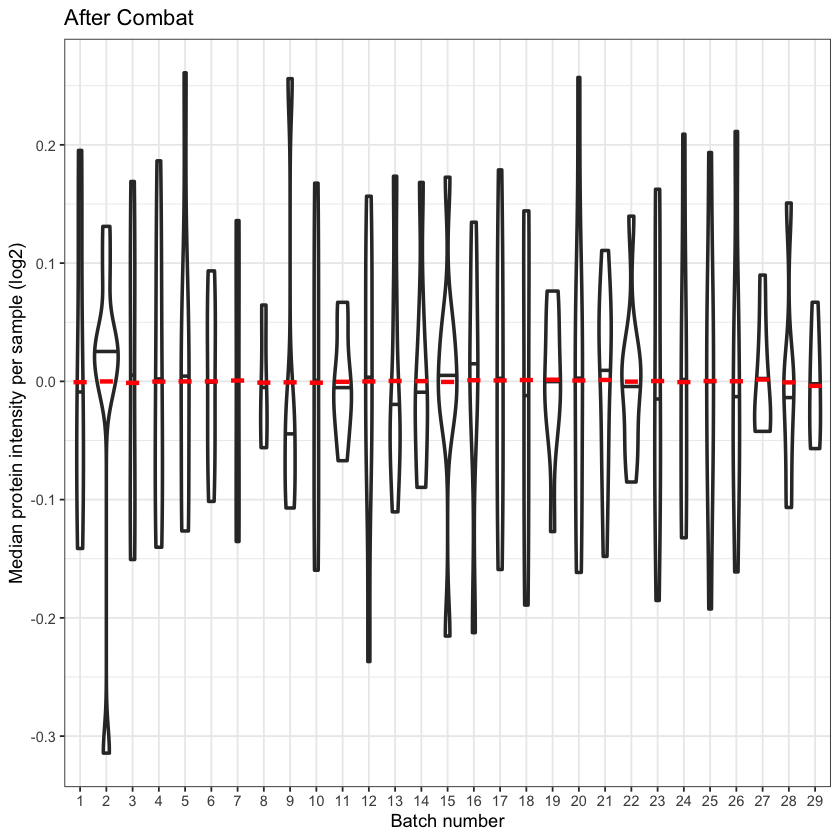

In [204]:
p <- ggplot(expression_summary, aes(x = as.factor(batch), y = totalEXP_Combat_std)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    stat_summary(fun = "mean",
               geom = "crossbar", 
               width = 0.5,
               colour = "red") +
    xlab("Batch number") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("After Combat") +
    theme_bw()
p

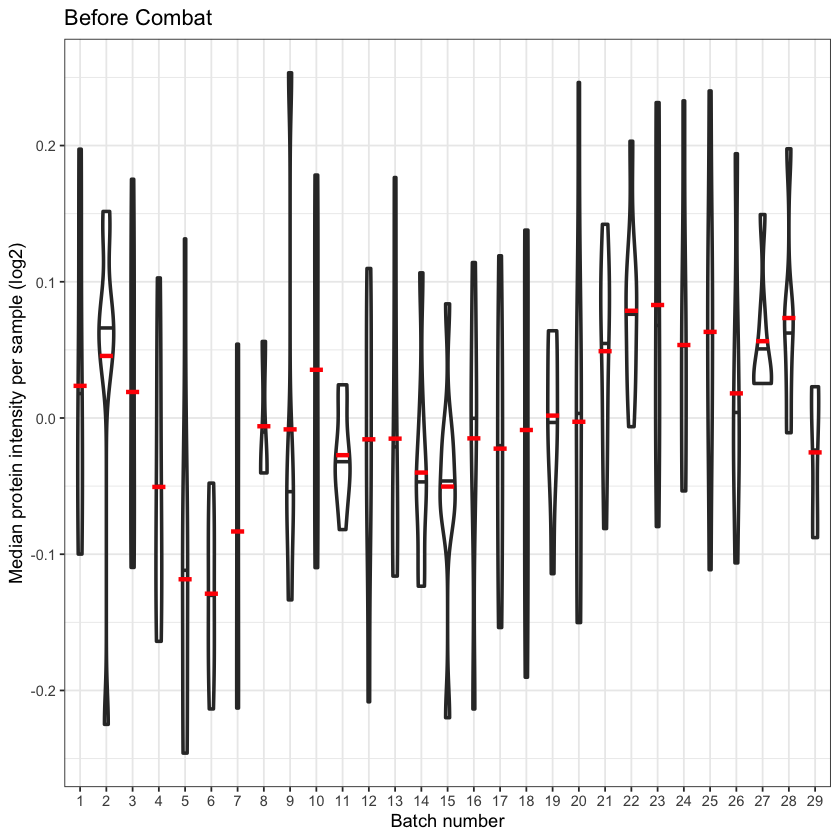

In [205]:
p <- ggplot(expression_summary, aes(x = as.factor(batch), y = totalEXP_orig_std)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    stat_summary(fun = "mean",
               geom = "crossbar", 
               width = 0.5,
               colour = "red") +
    xlab("Batch number") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("Before Combat") +
    theme_bw()
p

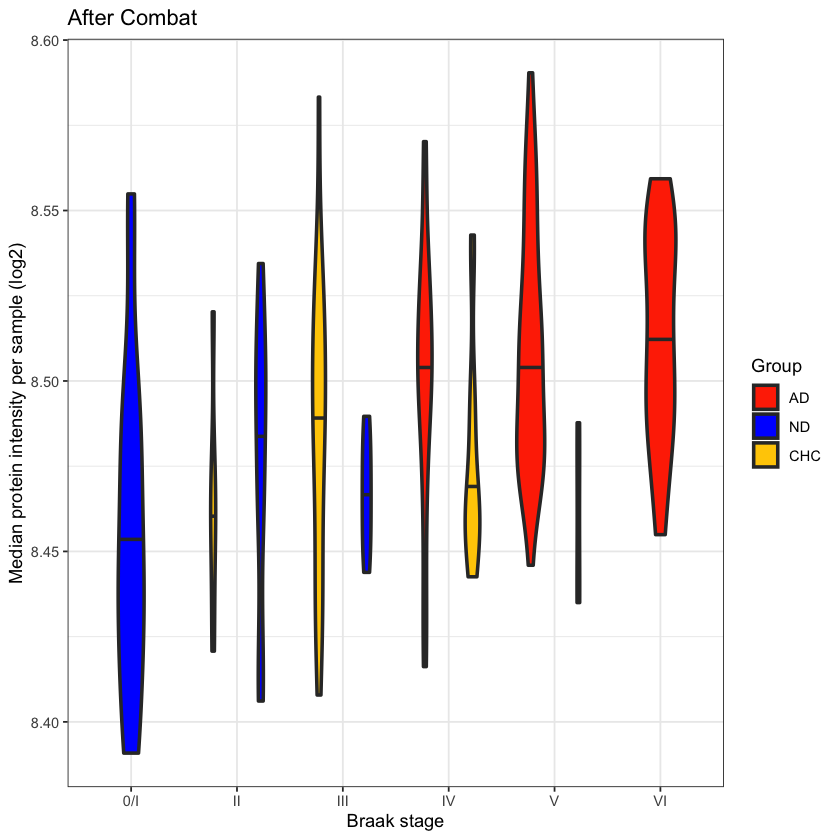

In [206]:
p <- ggplot(expression_summary, aes(x = as.factor(fBraak), y = totalEXP_Combat, fill = GROUP)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    #stat_summary(fun = "mean",
    #           geom = "crossbar", 
    #           width = 0.5,
    #           colour = "red") +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CHC"),
                               values = c(color_AD, color_ND, color_CHC)
                          ) +
    xlab("Braak stage") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("After Combat") +
    scale_x_discrete(breaks=1:6, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    theme_bw()
p

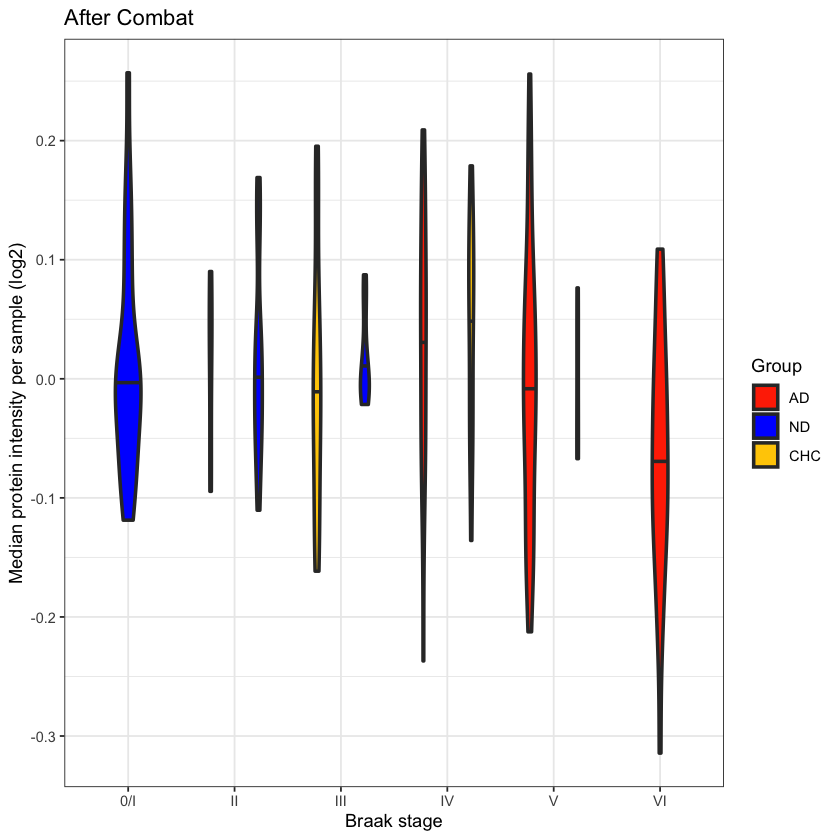

In [207]:
p <- ggplot(expression_summary, aes(x = as.factor(fBraak), y = totalEXP_Combat_std, fill = GROUP)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    #stat_summary(fun = "mean",
    #           geom = "crossbar", 
    #           width = 0.5,
    #           colour = "red") +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CHC"),
                               values = c(color_AD, color_ND, color_CHC)
                          ) +
    xlab("Braak stage") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("After Combat") +
    scale_x_discrete(breaks=1:6, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    theme_bw()
p

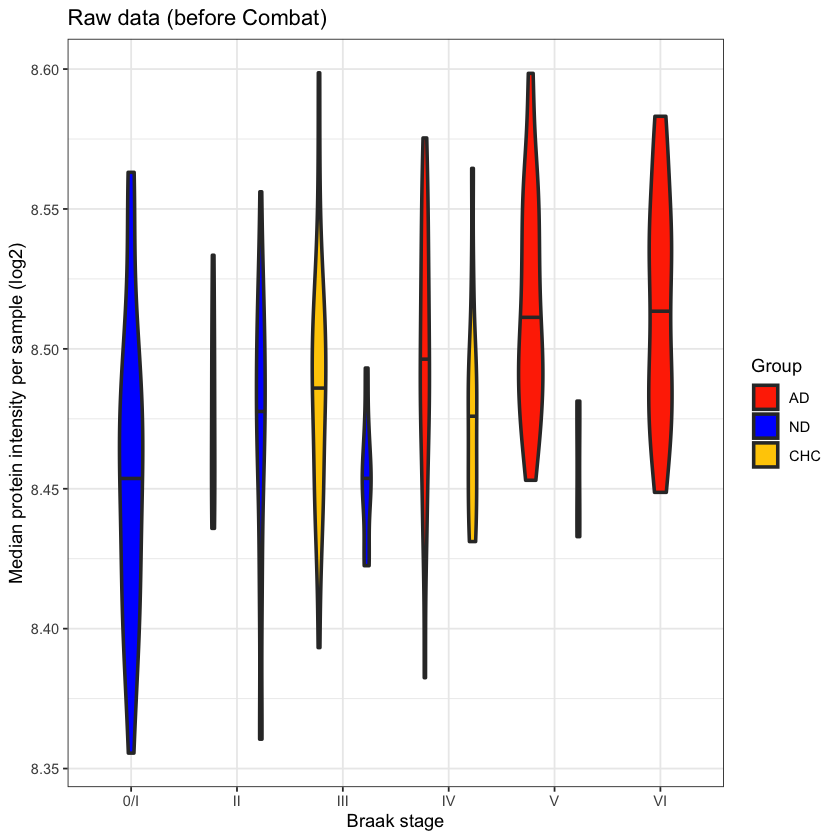

In [405]:
p <- ggplot(expression_summary, aes(x = as.factor(fBraak), y = totalEXP_orig, fill = GROUP)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    #stat_summary(fun = "mean",
    #           geom = "crossbar", 
    #           width = 0.5,
    #           colour = "red") +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CHC"),
                               values = c(color_AD, color_ND, color_CHC)
                          ) +
    xlab("Braak stage") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("Raw data (before Combat)") +
    scale_x_discrete(breaks=1:6, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    theme_bw()
p

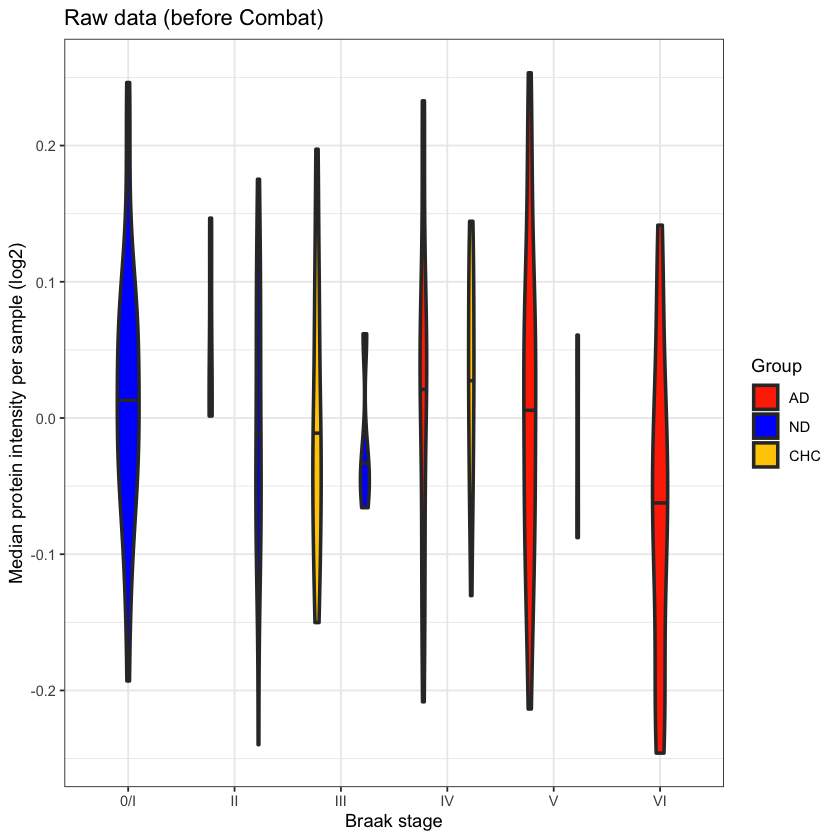

In [406]:
p <- ggplot(expression_summary, aes(x = as.factor(fBraak), y = totalEXP_orig_std, fill = GROUP)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    #stat_summary(fun = "mean",
    #           geom = "crossbar", 
    #           width = 0.5,
    #           colour = "red") +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CHC"),
                               values = c(color_AD, color_ND, color_CHC)
                          ) +
    xlab("Braak stage") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("Raw data (before Combat)") +
    scale_x_discrete(breaks=1:6, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    theme_bw()
p

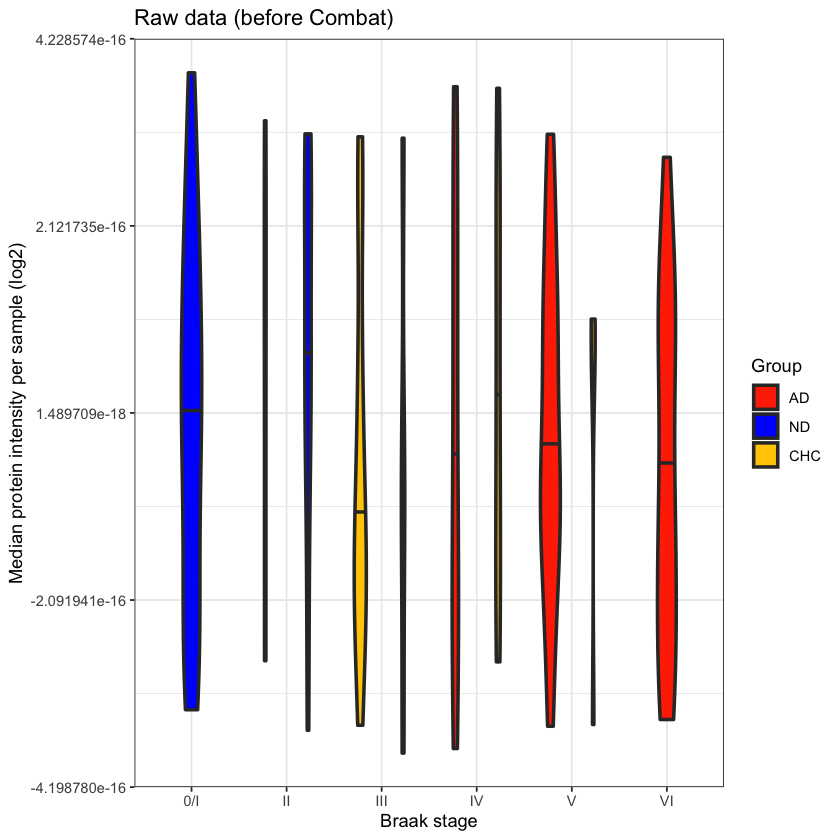

In [407]:
p <- ggplot(expression_summary, aes(x = as.factor(fBraak), y = totalEXP_orig_std_sample, fill = GROUP)) + 
    geom_violin(scale = "count", draw_quantiles = c(0.5), size = 1) + 
    #geom_jitter(height = 0, width = 0.1, alpha = .3) +
    #stat_summary(fun = "mean",
    #           geom = "crossbar", 
    #           width = 0.5,
    #           colour = "red") +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CHC"),
                               values = c(color_AD, color_ND, color_CHC)
                          ) +
    xlab("Braak stage") + 
    ylab("Median protein intensity per sample (log2)") +
    ggtitle("Raw data (before Combat)") +
    scale_x_discrete(breaks=1:6, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    theme_bw()
p

In [344]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}


cal_effect_size_mmd_median_log <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(max(intens) - min(intens))
    else
        return(min(intens) - max(intens))
}

In [380]:
Braak_test_index <- which((metadata$GROUP != "CHC"))
length(Braak_test_index)

[1] 141

In [381]:
pathology_related_proteins_ANOVA <- as.data.frame(apply(High_quality_protein_intensity_log2[, Braak_test_index], 1, 
                                                        cal_ANOVA_test, metadata[Braak_test_index, ]$fBraak))
colnames(pathology_related_proteins_ANOVA) <- c("p_value")
pathology_related_proteins_ANOVA$adjusted_p_value <- p.adjust(pathology_related_proteins_ANOVA$p_value,
                                                              method="BH")

#pathology_related_proteins_ANOVA$effect_size<- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
#                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)

In [382]:
pathology_related_proteins_ANOVA$effect_size <- apply(High_quality_protein_intensity_log2[, Braak_test_index], 1, 
                                                      cal_effect_size_mmd_median_log, metadata[Braak_test_index, ]$fBraak)

In [383]:
top_percent_p <- 0.05
top_percent_lfc <- 0.05

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)
top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]
topT_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(topT_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)
top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]
topT_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(topT_up_ANOVA)

[1] 15

[1] 33

In [384]:
top_percent_p <- 0.20
top_percent_lfc <- 0.20

## Top down-regulating proteins ##
## Top down-regulating proteins ##

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)

top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]

top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)

top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]

top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)

[1] 144

[1] 197

In [385]:
pathology_related_proteins_ANOVA

p_value      adjusted_p_value effect_size
1    7.305975e-06 3.002503e-05     -0.4562700 
2    6.074232e-13 2.493327e-11     -0.5955067 
3    3.097435e-02 5.194531e-02      0.4194094 
4    2.885321e-05 1.011035e-04      2.0234473 
5    8.165855e-04 2.040280e-03      0.4668245 
6    2.173016e-04 6.176882e-04      0.9093850 
7    1.104778e-01 1.547981e-01     -0.8670862 
8    8.122255e-09 7.428524e-08      0.7276447 
9    2.911074e-08 2.230530e-07      1.5601299 
10   3.154527e-03 6.823595e-03     -0.1945983 
11   1.153566e-05 4.439167e-05     -0.4274988 
12   2.348478e-02 4.087608e-02      0.2852548 
13   2.743612e-02 4.683156e-02     -0.2730912 
14   1.176543e-03 2.840840e-03     -0.2877537 
15   1.779192e-02 3.198048e-02      0.6473433 
16   3.970012e-02 6.462984e-02     -0.1559167 
17   4.338784e-01 4.980069e-01     -0.1220251 
18   1.318439e-01 1.800387e-01     -0.1325896 
19   5.035270e-01 5.627751e-01      0.1480042 
20   1.034840e-05 4.052165e-05      0.8411725 
21   1.630242e-22 2.810538e-19     -1.2215190 
22   4.706097e-09 4.570880e-08      1.3605779 
23   5.343224e-05 1.747954e-04      0.4864868 
24   7.475853e-13 2.962844e-11     -0.3895041 
25   5.513710e-02 8.621891e-02      0.4977721 
26   2.787812e-14 2.089647e-12     -0.4116748 
27   3.725732e-04 1.003619e-03     -0.6997205 
28   9.632651e-01 9.705839e-01     -0.2161448 
29   5.346392e-14 3.545069e-12     -0.3643604 
30   1.365195e-01 1.853956e-01      0.5878159 
⋮    ⋮            ⋮                ⋮          
3419 1.125187e-01 1.570070e-01     -0.3959795 
3420 1.228883e-01 1.694876e-01      0.4948672 
3421 1.815071e-01 2.362538e-01      0.3277617 
3422 2.088440e-01 2.662086e-01      0.2492824 
3423 8.825504e-03 1.722147e-02     -0.5641707 
3424 2.454813e-01 3.067849e-01      0.3111767 
3425 7.151235e-03 1.427762e-02     -0.4233088 
3426 1.529649e-01 2.046654e-01     -0.5155230 
3427 4.237214e-03 8.897634e-03     -0.2918526 
3428 2.203300e-01 2.795062e-01     -0.4662650 
3429 9.697200e-04 2.374712e-03     -0.3842774 
3430 4.457881e-11 8.587025e-10      1.7560240 
3431 1.371672e-11 3.217363e-10     -0.5326685 
3432 8.277949e-02 1.216640e-01     -0.2546479 
3433 2.102366e-01 2.677857e-01     -0.3468794 
3434 1.686404e-01 2.216892e-01     -0.2193092 
3435 2.955984e-04 8.140761e-04      0.7006628 
3436 2.771829e-01 3.407225e-01      0.2130377 
3437 5.586229e-03 1.145825e-02     -0.5549603 
3438 5.521045e-01 6.092699e-01     -0.3145615 
3439 9.565156e-02 1.368492e-01      0.4925248 
3440 1.253984e-01 1.725354e-01      0.3008941 
3441 1.110962e-01 1.555888e-01     -0.4602880 
3442 2.317182e-02 4.039254e-02      0.3643363 
3443 5.181521e-04 1.361729e-03      1.1699442 
3444 3.273476e-04 8.901377e-04      0.9734329 
3445 1.357369e-06 6.908770e-06      0.8126223 
3446 6.554937e-03 1.324044e-02     -0.3448199 
3447 9.337226e-04 2.301269e-03      0.3531758 
3448 1.565104e-07 1.010577e-06      0.5477200

In [386]:
cell_type_matrix

protein                            genesymbol HUGO_gene celltype        
1    SLC12A2                            SLC12A2    SLC12A2   Oligodendrocytes
2    CASKIN1                            CASKIN1    CASKIN1   NA              
3    GNG2                               GNG2       GNG2      NA              
4    CARNS1                             CARNS1     CARNS1    Oligodendrocytes
5    FH                                 FH         FH        NA              
6    EFHD2                              EFHD2      EFHD2     NA              
7    PCLO                               PCLO       PCLO      NA              
8    HSPA1A;HSPA1B                      HSPA1A     HSPA1A    NA              
9    STIP1                              STIP1      STIP1     NA              
10   CTNND1                             CTNND1     CTNND1    NA              
11   INPP5A                             INPP5A     INPP5A    NA              
12   SEPT11                             SEPT11     SEPTIN11  NA              
13   PKP4                               PKP4       PKP4      NA              
14   RYR2                               RYR2       RYR2      ExNeurons       
15   PTPRK                              PTPRK      PTPRK     NA              
16   CAMKV                              CAMKV      CAMKV     NA              
17   BCR                                BCR        BCR       Unknown         
18   NDUFV2                             NDUFV2     NDUFV2    NA              
19   IDH3B                              IDH3B      IDH3B     NA              
20   FMNL2                              FMNL2      FMNL2     NA              
21   SYT12                              SYT12      SYT12     NA              
22   GRHPR                              GRHPR      GRHPR     NA              
23   CSE1L                              CSE1L      CSE1L     NA              
24   DNAJC6                             DNAJC6     DNAJC6    NA              
25   DUSP3                              DUSP3      DUSP3     NA              
26   VDAC3                              VDAC3      VDAC3     NA              
27   PITPNM3                            PITPNM3    PITPNM3   NA              
28   SRPK2                              SRPK2      SRPK2     NA              
29   AP2A1                              AP2A1      AP2A1     NA              
30   RCN1                               RCN1       RCN1      NA              
⋮    ⋮                                  ⋮          ⋮         ⋮               
3419 KLC1;KLC2;KLC4                     KLC1       KLC1      NA              
3420 TM9SF3                             TM9SF3     TM9SF3    NA              
3421 PLEKHA6                            PLEKHA6    PLEKHA6   NA              
3422 KCTD12;KCTD16                      KCTD12     KCTD12    Microglia       
3423 SLC16A7                            SLC16A7    SLC16A7   NA              
3424 PPP3CA;PPP3CB;PPP3CC               PPP3CA     PPP3CA    NA              
3425 EHD3;EHD4                          EHD3       EHD3      NA              
3426 PEX14                              PEX14      PEX14     NA              
3427 TUBB;TUBB4A;TUBB4B                 TUBB       TUBB      NA              
3428 TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3 TUBA1A     TUBA1A    NA              
3429 PTPRD;PTPRF                        PTPRD      PTPRD     NA              
3430 H1F0                               H1F0       H1-0      NA              
3431 FAM210A                            FAM210A    FAM210A   NA              
3432 EPB41;EPB41L1;EPB41L3              EPB41      EPB41     NA              
3433 PABPN1                             PABPN1     PABPN1    NA              
3434 KCND2;KCND3                        KCND2      KCND2     NA              
3435 JMJD7;PLA2G4B                      JMJD7      JMJD7     NA              
3436 U2AF1;U2AF1L4;U2AF1L5              U2AF1      U2AF1     NA              
3437 ATP6V1G1;ATP6V1G2                  ATP6V1G1   ATP6V1G1  NA              
3438 ATP5J2;ATP5MF         

In [387]:
generate_data_matrix_for_plot <- function(data, sig_index){
    data$gene <- cell_type_matrix$protein

    data$alpha <- 1
    data[-sig_index,]$alpha <- 0.2
    
    return(data)
}

In [388]:
plot_volcano <- function(data, sig_index, label_index, xlab){
    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
    
    labels <- rep(NA, nrow(data_matrix))
    labels[label_index] <- data_matrix[label_index,]$gene
    
    multiple_names_idx <- grep(";", labels)
    labels[multiple_names_idx] <- sapply(labels[multiple_names_idx], function(x){
                                            return(paste(unlist(str_split(x, ";"))[1], "[1]", sep=""))
    })
    data_matrix$labels <- labels
    
    #print(labels[label_index])

    data_matrix$labels <- labels
    
    p <- ggplot(data=data_matrix, aes(x=effect_size, y=-log10(adjusted_p_value), label = labels)) +
        
        geom_point(size = 2, alpha = data_matrix$alpha) +
  
        geom_text_repel(size=3, show.legend = FALSE, parse=TRUE, na.rm=TRUE) +
        xlab(xlab) + ylab("-log10(P value) FDR") +
    
    
        theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          legend.position = "right",
          legend.direction = "vertical",
          
          legend.text = element_text(size = 8, color = "black", face = "bold"),
          
          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "gray")
          #legend.position = "none")
              )
    return(p)
    
}

In [390]:
pdf("Temp_results/volcano_plot_for_ANOVA_test_original.pdf")
p1 <- plot_volcano(pathology_related_proteins_ANOVA, 
                              c(top_down_ANOVA, top_up_ANOVA), 
                              c(topT_down_ANOVA, topT_up_ANOVA), "Fold Change (log2)")
p1
dev.off()

pdf 
  2

In [392]:
MAPT_idx <- which(rownames(protein_intensity_combat) == "MAPT")

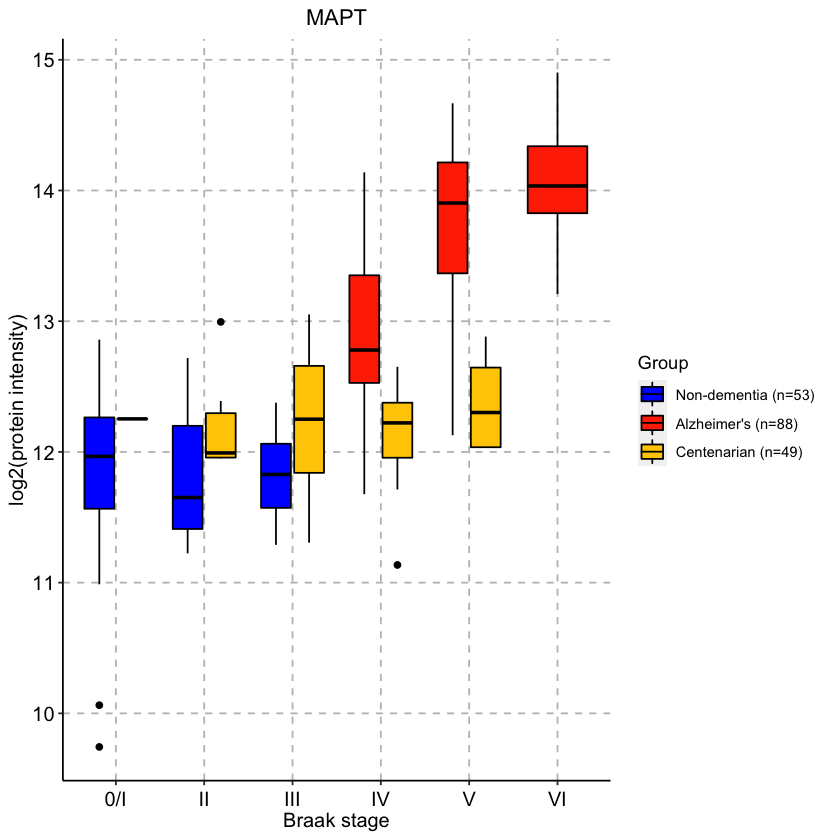

In [402]:
temp_prot <- data.frame(Braak = as.factor(metadata$fBraak),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(High_quality_protein_intensity_log2[MAPT_idx,]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))

xlabels <- sort(unique(temp_prot$Braak))
legend_p <- ggplot(temp_prot, aes(x = Braak, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("log2(protein intensity)") +
    ggtitle(rownames(protein_intensity_combat)[MAPT_idx]) +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                      values = c(color_ND, color_AD, color_CHC_M), 
                      labels = c("Non-dementia (n=53)", 
                                 "Alzheimer's (n=88)",
                                 "Centenarian (n=49)"))+

    theme(#plot.background = element_rect(),    # Background of the entire plot
      panel.background = element_rect(fill = "white"),   # Background of plotting area
      #panel.border = element_rect(),       # Border around plotting area.
                                           # fill argument should be NA
        legend.position="right",

      panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Vertical major grid lines
      panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Horizontal major grid lines
      panel.grid.minor.x = element_line(), # Vertical minor grid lines
      panel.grid.minor.y = element_line(),  # Vertical major grid lines
    
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_text(color = "black", size = 12),
      axis.title.y = element_text(color = "black", size = 12),
      
      axis.text.x = element_text(size = 12, color = "black", 
                                 vjust = 0.5, hjust = 0.5),
      axis.text.y = element_text(size = 12, color = "black"),
      
      axis.line = element_line(size = 0.5, linetype = "solid",
                               colour = "black")
     )
legend_p

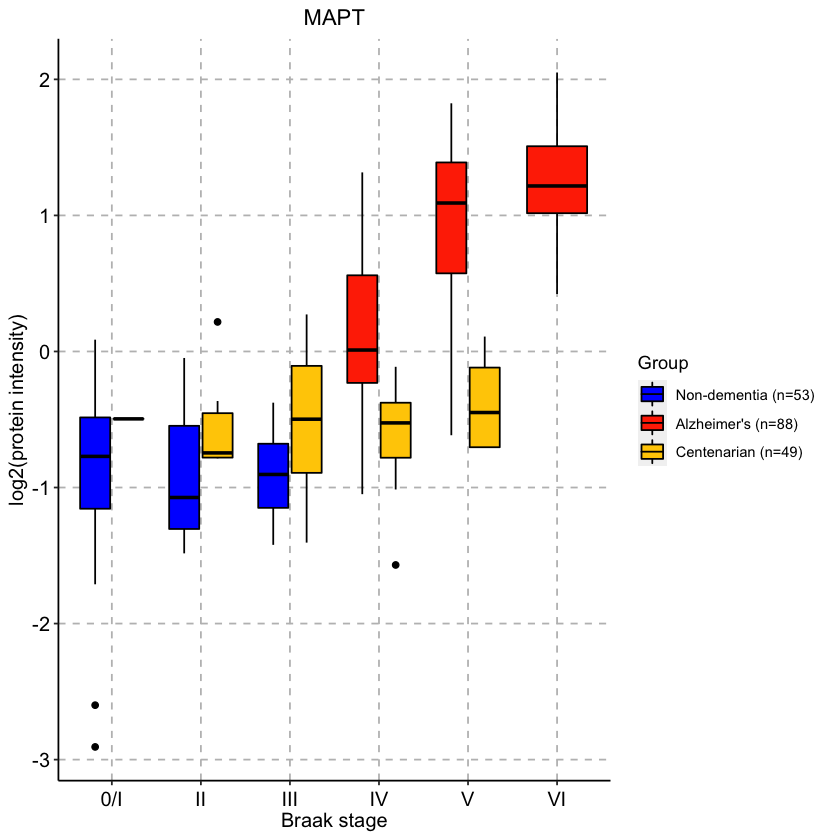

In [404]:
temp_prot <- data.frame(Braak = as.factor(metadata$fBraak),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(High_quality_protein_intensity_std[MAPT_idx,]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))

xlabels <- sort(unique(temp_prot$Braak))
legend_p <- ggplot(temp_prot, aes(x = Braak, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("log2(protein intensity)") +
    ggtitle(rownames(protein_intensity_combat)[MAPT_idx]) +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                      values = c(color_ND, color_AD, color_CHC_M), 
                      labels = c("Non-dementia (n=53)", 
                                 "Alzheimer's (n=88)",
                                 "Centenarian (n=49)"))+

    theme(#plot.background = element_rect(),    # Background of the entire plot
      panel.background = element_rect(fill = "white"),   # Background of plotting area
      #panel.border = element_rect(),       # Border around plotting area.
                                           # fill argument should be NA
        legend.position="right",

      panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Vertical major grid lines
      panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Horizontal major grid lines
      panel.grid.minor.x = element_line(), # Vertical minor grid lines
      panel.grid.minor.y = element_line(),  # Vertical major grid lines
    
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_text(color = "black", size = 12),
      axis.title.y = element_text(color = "black", size = 12),
      
      axis.text.x = element_text(size = 12, color = "black", 
                                 vjust = 0.5, hjust = 0.5),
      axis.text.y = element_text(size = 12, color = "black"),
      
      axis.line = element_line(size = 0.5, linetype = "solid",
                               colour = "black")
     )
legend_p

In [436]:
variance_per_gene <- data.frame(var = rowSds(High_quality_protein_intensity_log2))

In [437]:
rowmean_AD <- rowMeans(High_quality_protein_intensity_log2[, index_AD])
rowmean_ND <- rowMeans(High_quality_protein_intensity_log2[, index_ND])

In [438]:
variance_per_gene$regulated <- "Up"
variance_per_gene[which((rowmean_AD - rowmean_ND) < 0), ]$regulated <- "Down"

In [439]:
#variance_per_gene

In [441]:
pdf("Temp_results/Standard_deviation_between_Up_and_Down.pdf")

p<-ggplot(variance_per_gene, aes(x=var, fill=regulated)) +
    geom_histogram(aes(y=..density..), alpha=0.5, 
                position="identity")+
    geom_density(alpha=.2) +
    xlab("Standard deviation") +
    ylab("Density") +

    scale_fill_manual(name="Regulated", breaks = c("Up", "Down"), 
                      values = c('#E41A1C', '#377EB8'))+

    theme(#plot.background = element_rect(),    # Background of the entire plot
      panel.background = element_rect(fill = "white"),   # Background of plotting area
      #panel.border = element_rect(),       # Border around plotting area.
                                           # fill argument should be NA
        legend.position="right",

      panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Vertical major grid lines
      panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Horizontal major grid lines
      panel.grid.minor.x = element_line(), # Vertical minor grid lines
      panel.grid.minor.y = element_line(),  # Vertical major grid lines
    
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_text(color = "black", size = 12),
      axis.title.y = element_text(color = "black", size = 12),
      
      axis.text.x = element_text(size = 12, color = "black", 
                                 vjust = 0.5, hjust = 0.5),
      axis.text.y = element_text(size = 12, color = "black"),
      
      axis.line = element_line(size = 0.5, linetype = "solid",
                               colour = "black")
     )
p

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


pdf 
  2